# Mini Project: Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms.  

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [1]:
import gym
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [2]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [3]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(14, 1, False)
End game! Reward:  -1.0
You lost :(

(8, 4, False)
(18, 4, False)
End game! Reward:  -1
You lost :(

(20, 5, False)
End game! Reward:  1.0
You won :)



### Part 1: MC Prediction: State Values

In this section, you will write your own implementation of MC prediction (for estimating the state-value function).

We will begin by investigating a policy where the player always sticks if the sum of her cards exceeds 18.  The function `generate_episode_from_limit` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [2]:
def generate_episode_from_limit(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        action = 0 if state[0] > 18 else 1
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit` function.*)

In [5]:
for i in range(3):
    print(generate_episode_from_limit(env))

[((18, 3, False), 1, 0), ((20, 3, False), 0, 1.0)]
[((12, 10, False), 1, -1)]
[((5, 9, False), 1, 0), ((15, 9, False), 1, -1)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `V`: This is a dictionary where `V[s]` is the estimated value of state `s`.  For example, if your code returns the following output:
```
{(4, 7, False): -0.38775510204081631, (18, 6, False): -0.58434296365330851, (13, 2, False): -0.43409090909090908, (6, 7, False): -0.3783783783783784, ...
```
then the value of state `(4, 7, False)` was estimated to be `-0.38775510204081631`.

If you are unfamiliar with how to use `defaultdict` in Python, you are encouraged to check out [this source](https://www.accelebrate.com/blog/using-defaultdict-python/).

In [3]:
from collections import defaultdict
import numpy as np
import sys

def mc_prediction_v(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionary of lists
    #returns = defaultdict(list)
    returns = defaultdict(int)
    
    # AE: I think I'll need another defaultdict to know how many times each state was encountered
    # AE: so that I can average out the cumulativ value in the end.
    N = defaultdict(float)

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        episode = generate_episode(env)
        
        # AE: splitting the moves of the episode into discrete collections of states, actions and rewards
        states, actions, rewards = zip(*episode)
        
        # AE: calculating corresponding gamma powers for diminishing rewards
        discount_coefficients = np.array([gamma**i for i in range(len(rewards) + 1)])
        
        for i, state in enumerate(states):
            # AE: counting occurences of this state
            N[state] += 1
            # AE: in generic case we would want to only do the sum here if the state is encountered the first time in this
            # AE: episode. But in black jack there are no two identical states in any episode, so we're good here.
            # AE:
            # AE: So what happens here is that we take the rewards row and knock off rewards from the head
            # AE: as we move on because each next move has fewer rewards left to take into account. At
            # AE: the same time we take the discount_coefficients row and knock elements off from the tail
            # AE: as we move on, because we have fewer and fewer of rewards to apply these discounts to and
            # AE: we want to apply discounts from the head to the tail. It will make more sense if this is tried
            # AE: out in console.
            returns[state] = returns[state] + sum(rewards[i:] * discount_coefficients[:-(i+1)])

    V = {state: (float)(returns[state]) / N[state] for state in N.keys()}
    return V

In [7]:
### AE: Prediction function from the solution for reference

#def mc_prediction_v(env, num_episodes, generate_episode, gamma=1.0):
#    # initialize empty dictionary of lists
#    returns = defaultdict(list)
#    # loop over episodes
#    for i_episode in range(1, num_episodes+1):
#        # monitor progress
#        if i_episode % 1000 == 0:
#            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
#            sys.stdout.flush()
#        # generate an episode
#        episode = generate_episode(env)
#        # obtain the states, actions, and rewards
#        states, actions, rewards = zip(*episode)
#        # prepare for discounting
#        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
#        # calculate and store the return for each visit in the episode
#        for i, state in enumerate(states):
#            returns[state].append(sum(rewards[i:]*discounts[:-(1+i)]))
#    # calculate the state-value function estimate
#    V = {k: np.mean(v) for k, v in returns.items()}
#    return V

Use the cell below to calculate and plot the state-value function estimate.  (_The code for plotting the value function has been borrowed from [this source](https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py) and slightly adapted._)

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 500000/500000.

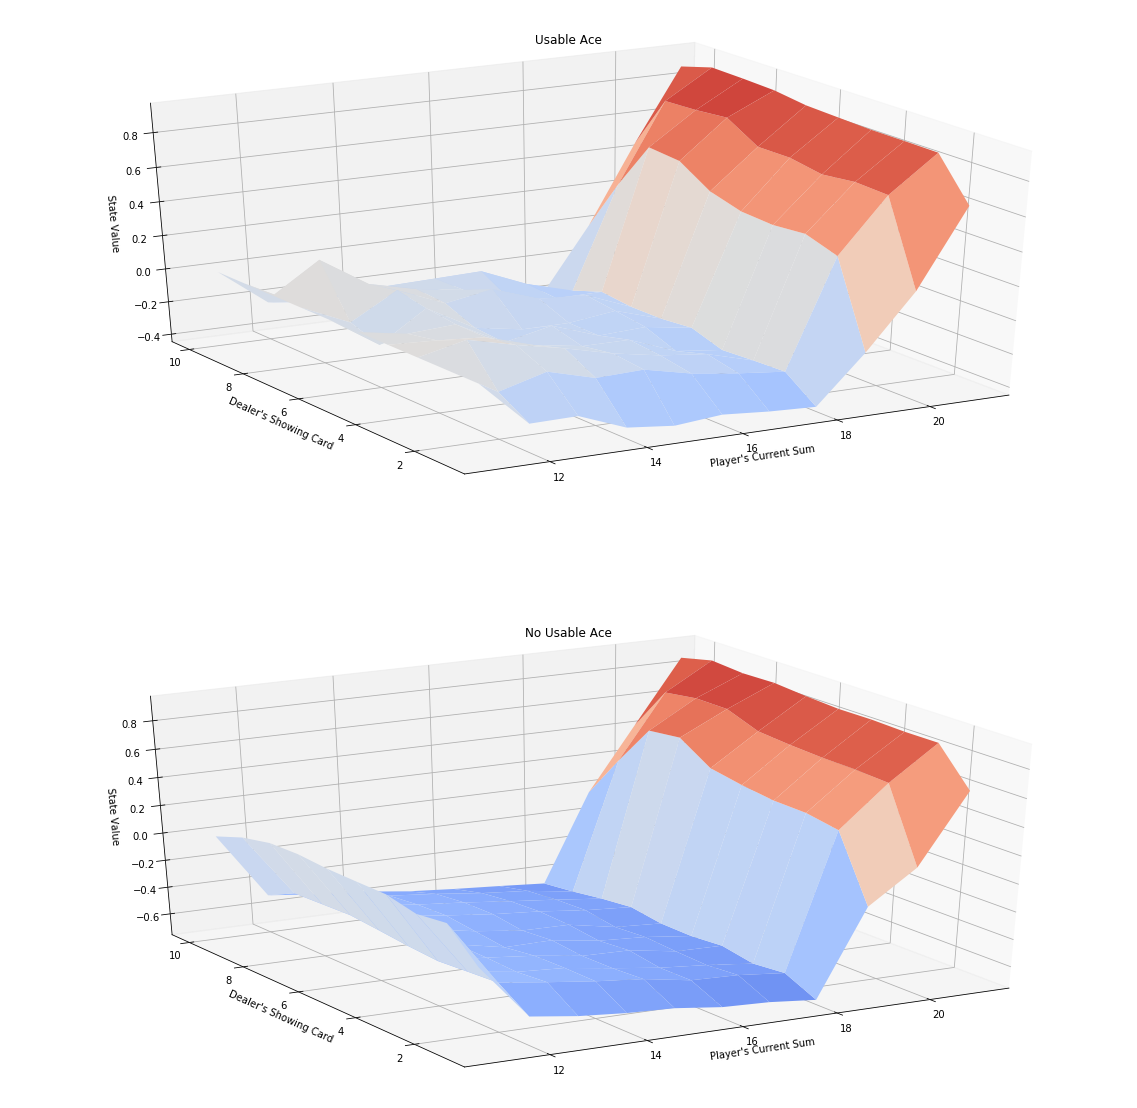

In [9]:
from plot_utils import plot_blackjack_values

# obtain the value function
V = mc_prediction_v(env, 500000, generate_episode_from_limit)

# plot the value function
plot_blackjack_values(V)

### Part 2: MC Prediction: Action Values

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [4]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [5]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        ## TODO: complete the function
        episode = generate_episode(env)

        # AE: splitting the moves of the episode into discrete collections of states, actions and rewards
        states, actions, rewards = zip(*episode)

        # AE: calculating corresponding gamma powers for diminishing rewards
        discount_coefficients = np.array([gamma**i for i in range(len(rewards) + 1)])

        for i, state in enumerate(states):
            action = actions[i]
            # AE: counting occurences of this state
            N[state][action] += 1.0 # counting occurences of a given state-action pair

            # AE: in generic case we would want to only do the sum here if the state is encountered the first time in this
            # AE: episode. But in black jack there are no two identical states in any episode, so we're good here.
            # AE:
            # AE: So what happens here is that we take the rewards row and knock off rewards from the head
            # AE: as we move on because each next move has fewer rewards left to take into account. At
            # AE: the same time we take the discount_coefficients row and knock elements off from the tail
            # AE: as we move on, because we have fewer and fewer of rewards to apply these discounts to and
            # AE: we want to apply discounts from the head to the tail. It will make more sense if this is tried
            # AE: out in console.
            returns_sum[state][action] += sum(rewards[i:] * discount_coefficients[:-(i+1)])

    Q = {state: returns_sum[state] / N[state] for state in N.keys()}
    
    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 500000/500000.

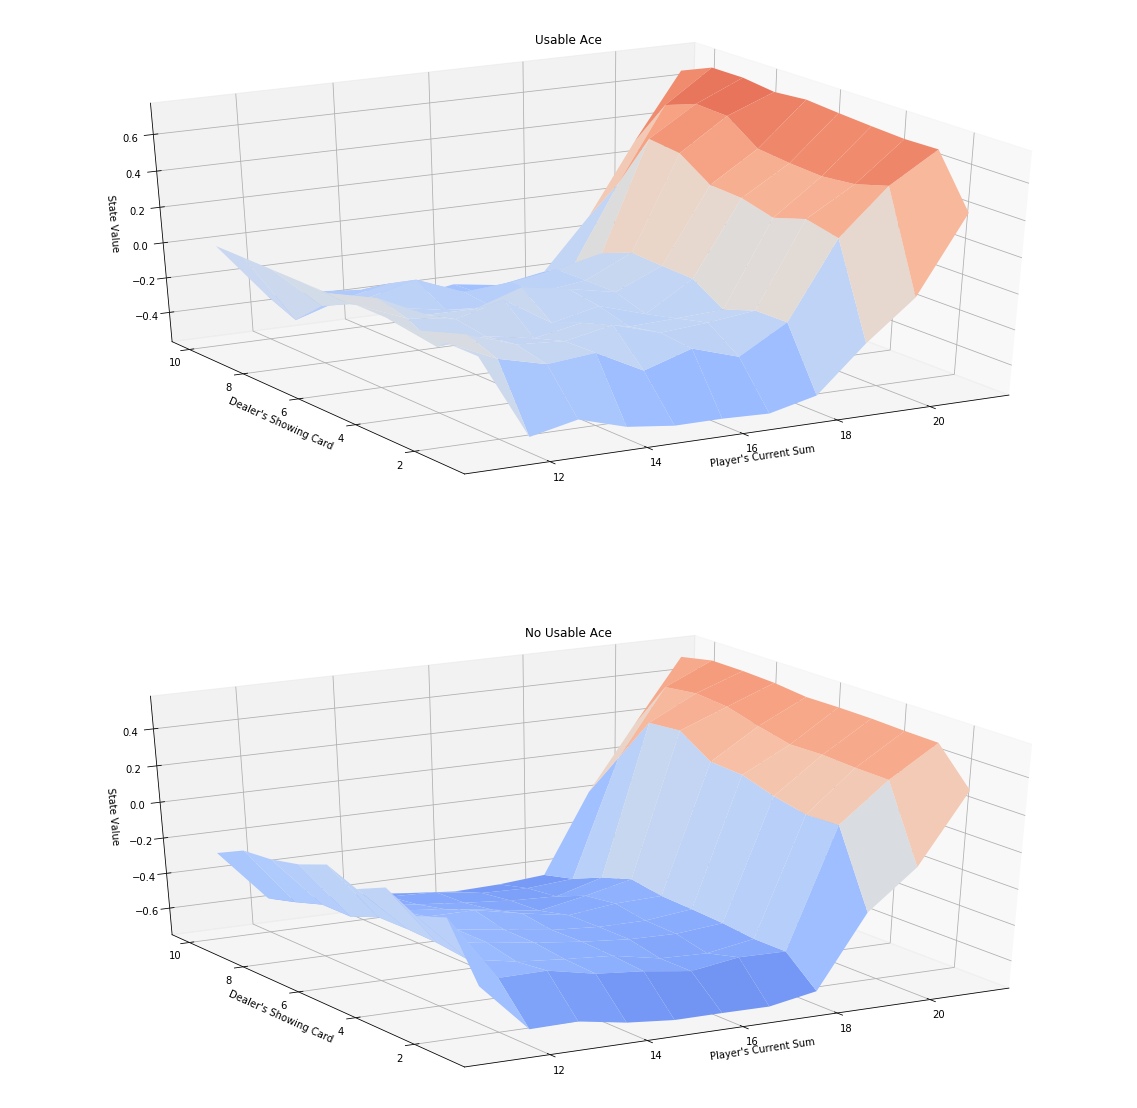

In [25]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 3: MC Control: GLIE

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [6]:
### AE: By the way, I don't think that this is supposed to be a "constant-alpha" MC control algorithm
### AE: as opposed to the description of Part 3.
def mc_control_GLIE(env, num_episodes, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionaries of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        # AE: Updating epsilon based on the iteration and current policy based on the experience that we gained
        # AE: from the previous episode. Perhaps a clever "update_epsilon" function could update epsilon based
        # AE: on the experience too (especially if MDP keeps changing like in real life).
        epsilon = update_epsilon(i_episode)
        policy = epsilon_greedy_policy(Q, epsilon, nA)

        # AE: Now generate a new episode and evaluate how we fared in it with the current policy
        episode = generate_episode_from_current_knowledge(env, policy, nA)

        # AE: splitting the moves of the episode into discrete collections of states, actions and rewards
        states, actions, rewards = zip(*episode)

        # AE: calculating corresponding gamma powers for diminishing rewards
        discount_coefficients = np.array([gamma**i for i in range(len(rewards) + 1)])

        for i, state in enumerate(states):
            action = actions[i]
            # AE: counting occurences of this state
            N[state][action] += 1.0 # counting occurences of a given state-action pair

            # AE: in generic case we would want to only do the sum here if the state is encountered the first time in this
            # AE: episode. But in black jack there are no two identical states in any episode, so we're good here.
            # AE:
            # AE: So what happens here is that we take the rewards row and knock off rewards from the head
            # AE: as we move on because each next move has fewer rewards left to take into account. At
            # AE: the same time we take the discount_coefficients row and knock elements off from the tail
            # AE: as we move on, because we have fewer and fewer of rewards to apply these discounts to and
            # AE: we want to apply discounts from the head to the tail. It will make more sense if this is tried
            # AE: out in console.
            #returns_sum[state][action] += sum(rewards[i:] * discount_coefficients[:-(i+1)])

            # AE: doing the incremental mean for our actions
            Q[state][action] += (1 / N[state][action]) * (sum(rewards[i:] * discount_coefficients[:-(i+1)]) - Q[state][action])

    # AE: in the end we want to convert our Stoachastic policy that we have now into a concrete one that doesn't allow for
    # AE: probabilities, but instead just uses exploitation to the fullest. Instead of converting though, we can just take
    # AE: it from best action in the action-state function Q.
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    
    return policy, Q

### AE: a function that returns an epsilon-greedy policy for a given state-action function Q. It will make a decision for a
### AE: greedy action most of the time, but with some non-zero probability based on epsilon parameter it will select an 
### AE: exploratory action.
def epsilon_greedy_policy(Q, epsilon, number_of_actions):
    # AE: by default our policy will always STICK (action = 0). Perhaps we could improve that by choosing a random distribution
    # AE: between the actions by default. We're currently fixing that in "generate_episode_from_current_knowledge".
    policy = defaultdict(lambda: np.zeros(number_of_actions))

    for state, action_set in Q.items():
        # AE: here we only have two actions (STICK=0 and HIT=1) and could actually just use those two actions, but in general
        # AE: we may have more than two actions and the number of actions may differ for each state, so let's write it in the
        # AE: generic form.
        for action_ndx, action in enumerate(action_set): 
            #if (action_set[action_ndx] = ):
            if (action_ndx == np.argmax(action_set)):
                # AE: this could be improved to give bigger preference for higher values, not just either max or experiment.
                policy[state][action_ndx] = 1 - epsilon + epsilon / len(action_set)
            else:
                #print(state, action_set, Q)
                policy[state][action_ndx] = epsilon / len(action_set)

    return policy

### AE: With this function we will choose the appropriate epsilon value based on the number of iterations and the starting
### AE: epsilon value.
def update_epsilon(iteration, starting_eps=1):
    ### AE: In reality we would probably want a little bit more linear decay, than this
    ### AE: but for Black Jack this will do.
    #return 1.0 / (iteration + 1)
    # AE: Epsilon function is extremely important. The initial approach of (1 / iteration) was a lot worse than the current
    # AE: much more linear solution borrowed from the solution notebook.
    return 1.0/((iteration/8000)+1)

### AE: This function will generate an episode using a given policy.
### AE: In this exercise that will be a greedy-epsilon policy.
def generate_episode_from_current_knowledge(bj_env, policy, number_of_actions):
    episode = []
    state = bj_env.reset()
    while True:
        #probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        #print (policy[state])
        # AE: if probabilities of our actions don't add up to 1, then we haven't visited this state yet. In that case let's 
        # AE: choose the next action with 50-50 probability.
        if sum(policy[state]) == 0:
            policy[state] = [1 / number_of_actions for a in range(number_of_actions)]
        # AE: we'll need to normalise action utilities to be able to generate a probability for their selection
        #probs = [prob for (prob / sum(policy[state])) in policy[state]]
        action = np.random.choice(np.arange(number_of_actions), p=policy[state])
        #action = policy[state]
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Use the cell below to obtain the estimated optimal policy and action-value function.

In [56]:
# obtain the estimated optimal policy and action-value function
policy_glie, Q_glie = mc_control_GLIE(env, 500000)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

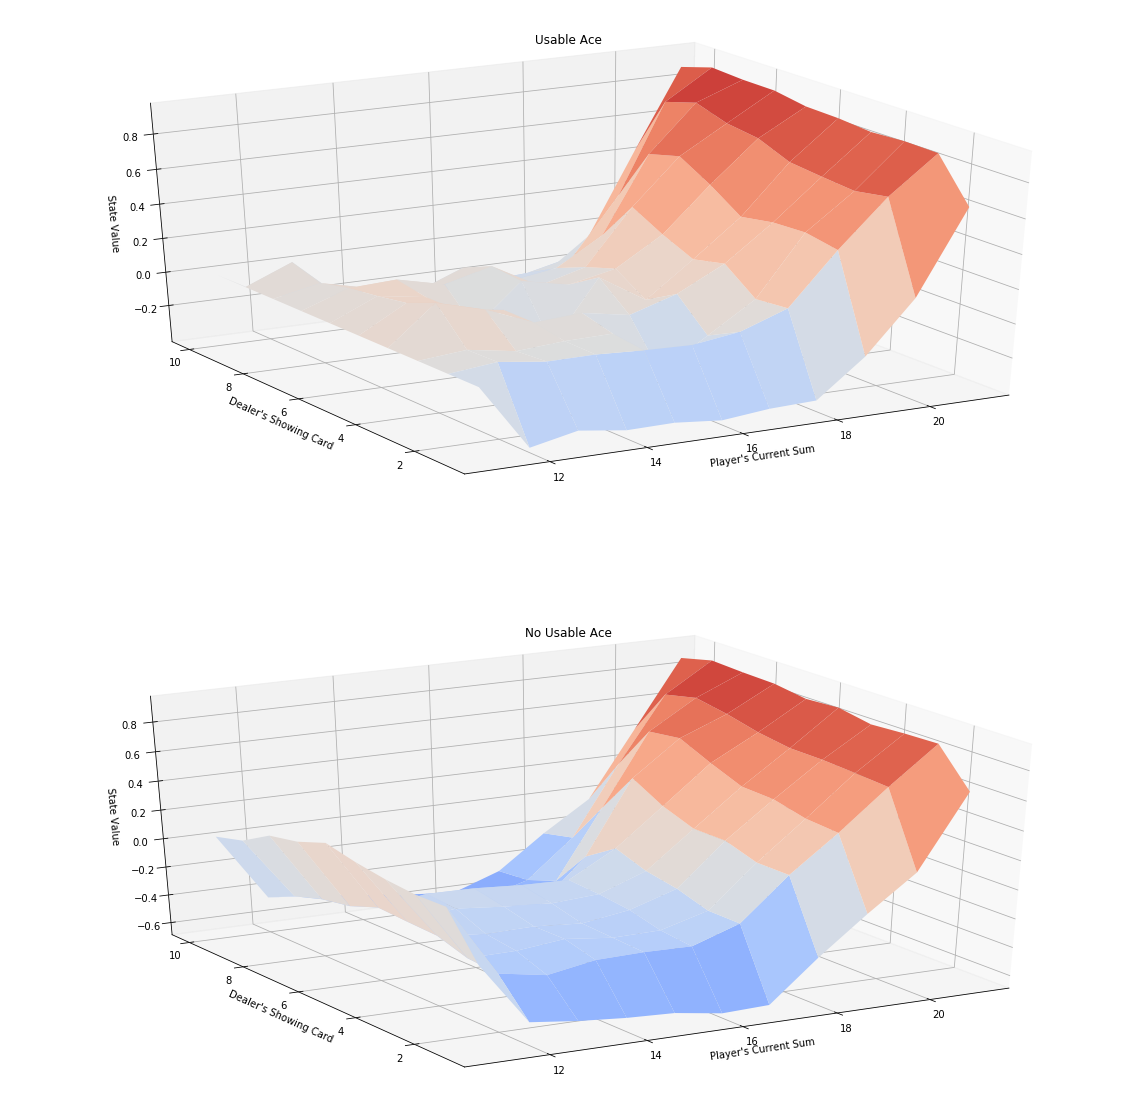

In [57]:
from plot_utils import plot_blackjack_values
# obtain the state-value function
V_glie = dict((k,np.max(v)) for k, v in Q_glie.items())

# plot the state-value function
plot_blackjack_values(V_glie)

Finally, we visualize the policy that is estimated to be optimal.

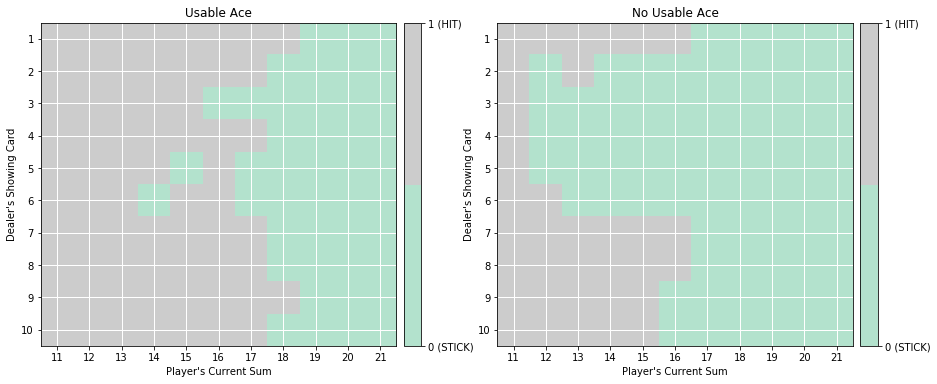

In [58]:
from plot_utils import plot_policy
#print(policy_glie)
# plot the policy
plot_policy(policy_glie)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$ and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)

### Part 4: MC Control: Constant-$\alpha$

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [7]:
def mc_control_alpha(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        ## TODO: complete the function
        # AE: Updating epsilon based on the iteration and current policy based on the experience that we gained
        # AE: from the previous episode. Perhaps a clever "update_epsilon" function could update epsilon based
        # AE: on the experience too (especially if MDP keeps changing like in real life).
        epsilon = update_epsilon(i_episode)
        policy = epsilon_greedy_policy(Q, epsilon, nA)

        # AE: Now generate a new episode and evaluate how we fared in it with the current policy
        episode = generate_episode_from_current_knowledge(env, policy, nA)

        # AE: splitting the moves of the episode into discrete collections of states, actions and rewards
        states, actions, rewards = zip(*episode)

        # AE: calculating corresponding gamma powers for diminishing rewards
        discount_coefficients = np.array([gamma**i for i in range(len(rewards) + 1)])

        for i, state in enumerate(states):
            action = actions[i]

            # AE: in generic case we would want to only do the sum here if the state is encountered the first time in this
            # AE: episode. But in black jack there are no two identical states in any episode, so we're good here.
            # AE:
            # AE: So what happens here is that we take the rewards row and knock off rewards from the head
            # AE: as we move on because each next move has fewer rewards left to take into account. At
            # AE: the same time we take the discount_coefficients row and knock elements off from the tail
            # AE: as we move on, because we have fewer and fewer of rewards to apply these discounts to and
            # AE: we want to apply discounts from the head to the tail. It will make more sense if this is tried
            # AE: out in console.
            #returns_sum[state][action] += sum(rewards[i:] * discount_coefficients[:-(i+1)])

            # AE: doing the incremental mean for our actions
            Q[state][action] += alpha * (sum(rewards[i:] * discount_coefficients[:-(i+1)]) - Q[state][action])

    # AE: in the end we want to convert our Stoachastic policy that we have now into a concrete one that doesn't allow for
    # AE: probabilities, but instead just uses exploitation to the fullest. Instead of converting though, we can just take
    # AE: it from best action in the action-state function Q.
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
        
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

In [8]:
# obtain the estimated optimal policy and action-value function
policy_alpha, Q_alpha = mc_control_alpha(env, 500000, 0.008)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

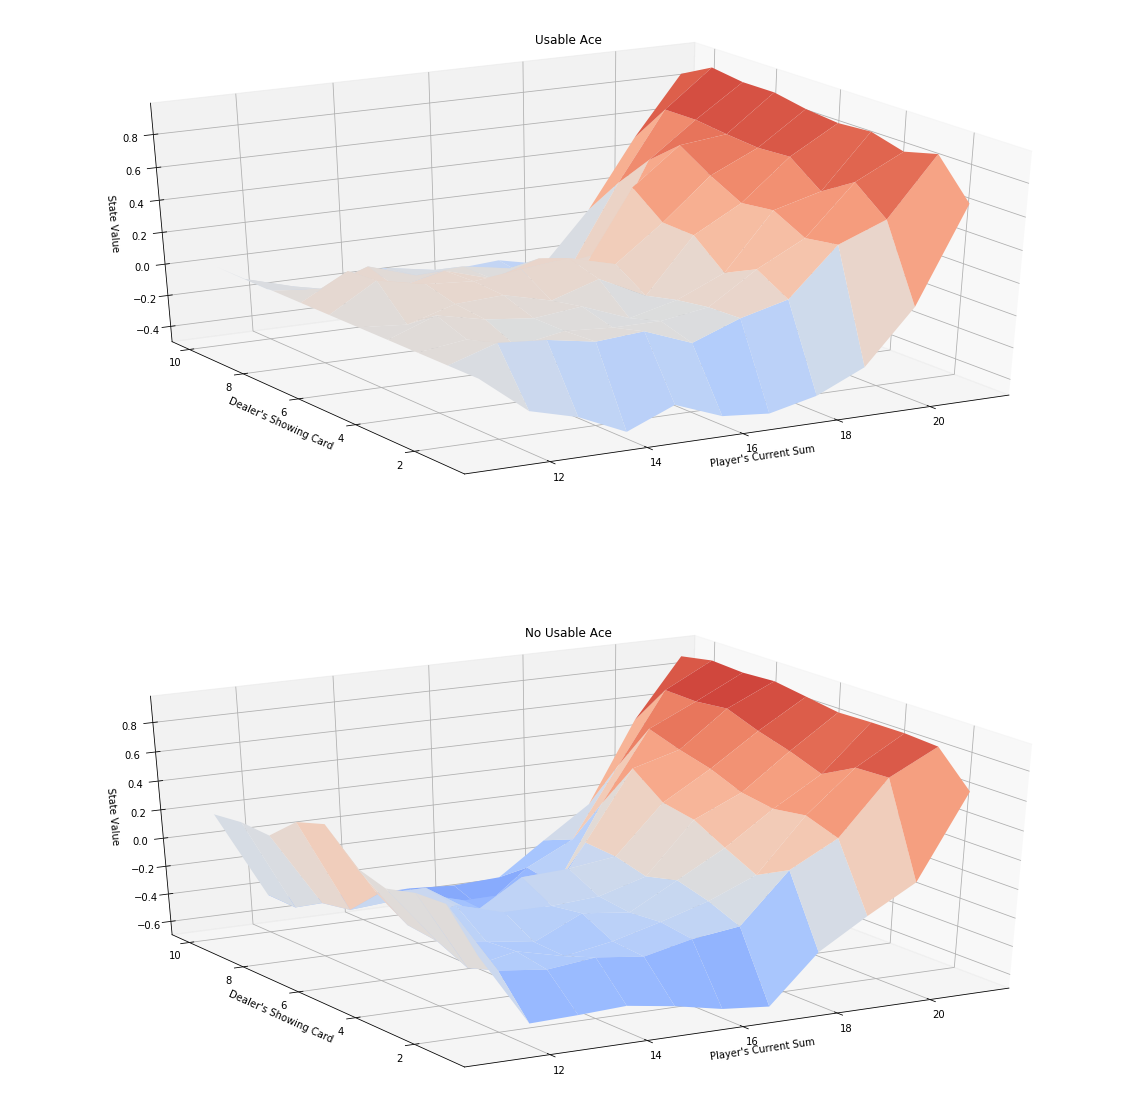

In [10]:
### AE: imports for graphics, so that I don't have to re-run functions above:
from plot_utils import plot_blackjack_values
from plot_utils import plot_policy

# obtain the state-value function
V_alpha = dict((k,np.max(v)) for k, v in Q_alpha.items())

# plot the state-value function
plot_blackjack_values(V_alpha)

Finally, we visualize the policy that is estimated to be optimal.

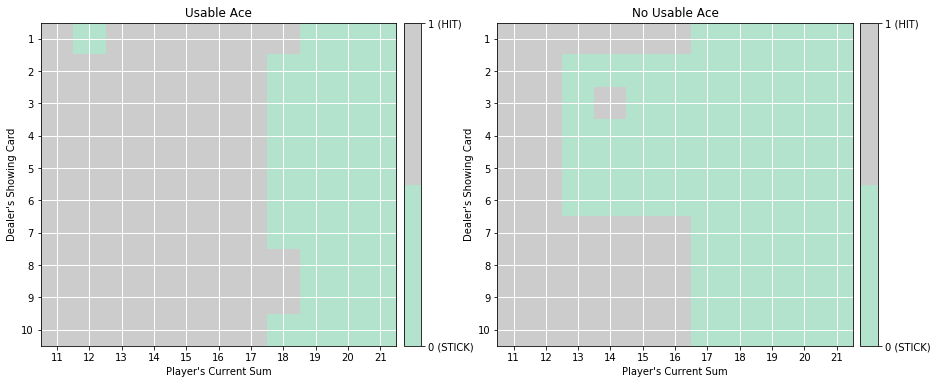

In [11]:
# plot the policy
plot_policy(policy_alpha)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)